In [2121]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')
from scipy import signal
from scipy.signal import firwin, freqz
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy import fftpack
import operator
import IPython.display as ipd

import scipy as sp
import cv2
import skimage.io
from scipy.io import wavfile
from matplotlib import image
from sklearn.preprocessing import MinMaxScaler
import math
from PIL import Image
import random
import scipy.signal as signal
from scipy.signal import remez
import scipy.io.wavfile as sw
from scipy.signal import filtfilt
from scipy import stats
from scipy.signal import butter




SEÑAL AUDIO ORIGINAL SIN FILTRAR

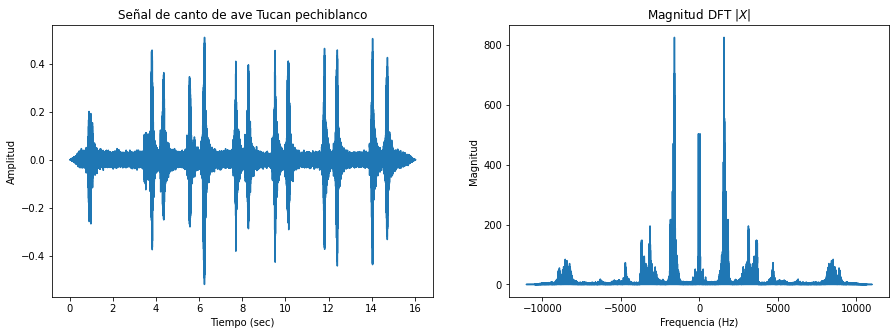

FS:  22050


In [2122]:
y, fs = librosa.load('CantoTucan.WAV')
t = np.arange(y.shape[0]) / fs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(t, y) 
plt.title('Señal de canto de ave Tucan pechiblanco')
plt.xlabel('Tiempo (sec)')
plt.ylabel('Amplitud')
x = np.fft.fft(y)

freq = np.fft.fftfreq(y.size, d=1/fs)
plt.subplot(1, 2, 2)
plt.plot(freq, np.abs(x))
plt.title('Magnitud DFT $|X|$')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitud') 
plt.show()
print("FS: ", fs)


ESPECTROGRAMA DE LA SEÑAL ORIGINAL

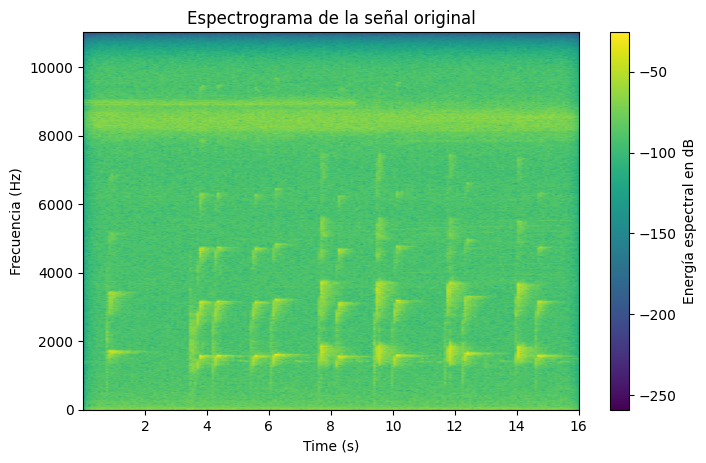

In [2123]:
plt.figure(figsize=(8, 5),dpi=100)
plt.specgram(y,Fs=fs,NFFT=2048,noverlap=256)
plt.title('Espectrograma de la señal original')
plt.xlabel('Time (s)')
plt.ylabel('Frecuencia (Hz)')
plt.colorbar(label="Energía espectral en dB")
plt.show()

In [2124]:
#Funcion para graficar respuesta en frecuencia
def graficarRespuestaFrecuencia(wz, hz, Fs ):
# Calcular Magnitud de Hz a dB
    Mag = 20*np.log10(abs(hz))

    # Calcular la fase
    fase = np.unwrap(np.arctan2(np.imag(hz), np.real(hz)))*(180/np.pi)
     
    # Calcular frecuencia
    Freq = wz*Fs/(2*np.pi)
     
    # Graficar magnitud y fase
    fig = plt.figure(figsize=(10, 6))
 
    # Graficar Respuesta en Magnitud
    sub1 = plt.subplot(2, 1, 1)
    sub1.plot(Freq, Mag,  linewidth=2)
    sub1.axis([1, Fs/2, -100, 5])
    sub1.set_title('Respuesta en Magnitud', fontsize=12)
    sub1.set_xlabel('Frecuencia [Hz]', fontsize=10)
    sub1.set_ylabel('Magnitud [dB]', fontsize=10)
    sub1.grid()
 
    # Graficar fase
    sub2 = plt.subplot(2, 1, 2)
    sub2.plot(Freq, fase,  linewidth=2)
    sub2.set_ylabel('Fase (grados)', fontsize=15)
    sub2.set_xlabel('Frecuencia (Hz)', fontsize=10)
    sub2.set_title('Fase', fontsize=10)
    sub2.grid()
 
    plt.subplots_adjust(hspace=0.5)
    fig.tight_layout()
    plt.show()

# FILTRO FIR POR VENTANAS MANUALMENTE USANDO VENTANA HAMMING

In [2125]:

M2 = 100
n2 = np.arange(0, M2, 1)
ventanaHamming = 0.54 - 0.46*np.cos(2*np.pi*n2/(M2-1))

def metodo_ventanas(N, fc, fs):
    ntaps = 128
    nyqFreq = 0.5 * fs

    fc = np.atleast_1d(fc) / float(nyqFreq)
    bandas = fc.reshape(-1, 2)

    alpha = 0.5 * (ntaps - 1)
    m = np.arange(0, ntaps) - alpha
    Filtro_hd = 0

    for left, right in bandas:
        Filtro_hd += right * np.sinc(right * m)
        Filtro_hd -= left * np.sinc(left * m)

    M = 128
    a = [ 0.54, 1. -  0.54]

    fac = np.linspace(-np.pi, np.pi, M)
    window = np.zeros(M)
    for k in range(len(a)):
        window += a[k] * np.cos(k * fac)

    Filtro_hd *= window

    ventanaResultante, filtroResultante = freqz(Filtro_hd, 1, worN=2000)
    Frecuencias = ventanaResultante*fs/(2*np.pi)

    return ventanaResultante, filtroResultante, Filtro_hd, Frecuencias

GRAFICOS RESULTANTES FILTRO FIR CON VENTANA HAMMING

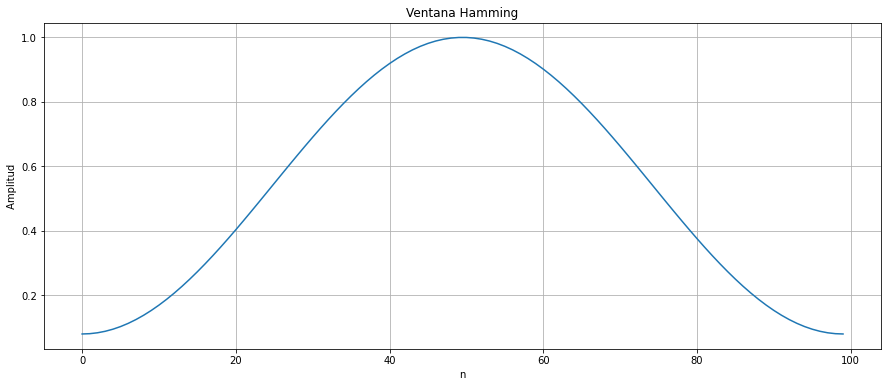

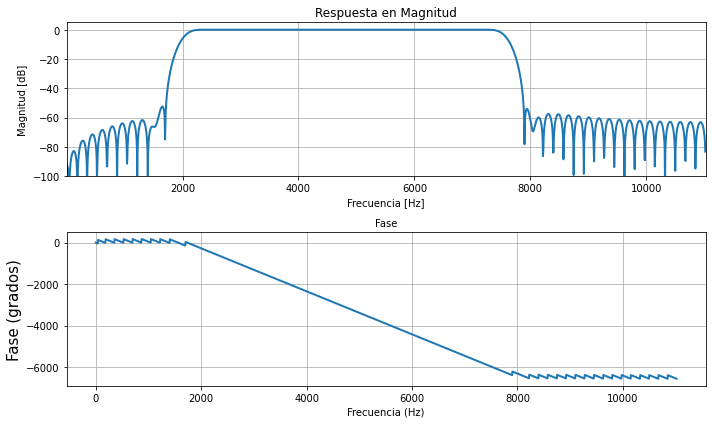

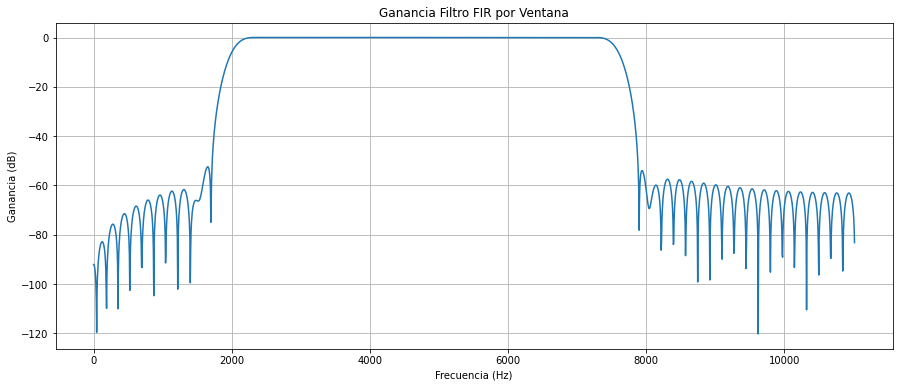

In [2126]:

N = y.shape[0] # Saca cantidad de puntos de la señal de audio
corteInferior = 2000 #Frecuencias de corte inferior 
corteSuperior = 7600 # Frecuencias de corte superior
corte = [corteInferior, corteSuperior] 

[ventana, filtro_normalizado, filtroResultante_hd, frequencies] = metodo_ventanas(N, corte, fs)

#Graficar Ventana Hamming
plt.figure(figsize = (15,6))
plt.plot(n2,ventanaHamming)
plt.grid()
plt.xlabel('n')
plt.ylabel(' Amplitud ')
plt.title('Ventana Hamming')

graficarRespuestaFrecuencia(ventana, filtro_normalizado, fs )

# Plotear Ganancia en Decibeles
plt.figure(figsize = (15,6))
plt.plot(frequencies, 20*np.log10((np.abs(filtro_normalizado))))
plt.grid()
plt.title('Ganancia Filtro FIR por Ventana')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia (dB)')

plt.show()

FILTRO FIR USANDO FIRWIN Y VENTANA HAMMING PARA COMPARAR

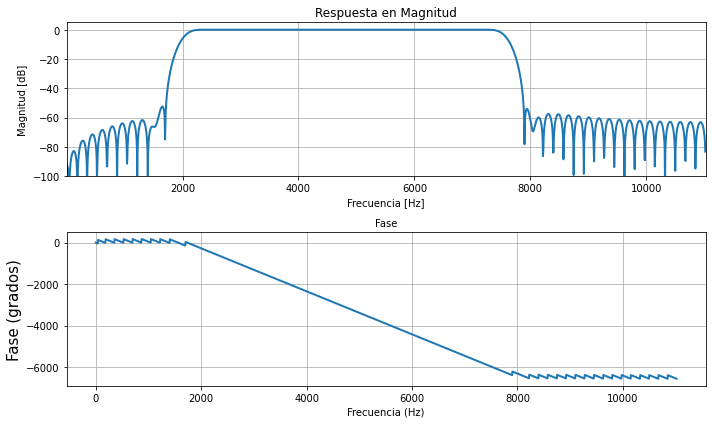

In [2127]:

def ventanaFIR_BandPass (ntaps, lowcut, highcut, fs, window='hamming'):
    taps = firwin(ntaps, [lowcut, highcut], fs=fs, pass_zero="bandpass", window=window, scale=False)
    return taps

ventanaFiltradaFirwin = ventanaFIR_BandPass(128, 2000, 7600, fs)
winFIRWIN, hFIRWIN = freqz(ventanaFiltradaFirwin, 1, worN=2000)
graficarRespuestaFrecuencia(winFIRWIN, hFIRWIN, fs )

Añadir filtro FIR a audio por metodo de Ventaneo

In [2128]:
import scipy.io.wavfile as sw
import soundfile as sf

#Reescribimos el audio del Tucan con el filtro FIR por Ventaneo
y, Fs = librosa.load("CantoTucan.wav")
audioVentana = signal.correlate(y, filtroResultante_hd, mode="same")
sf.write('resultadoVentanasFIR.wav',np.real(audioVentana/max(audioVentana)),Fs)
#ipd.Audio(audioVentana, rate=Fs)

RESPUESTA TEMPORAL Y EN FRECUENCIA FILTRO FIR POR VENTANA

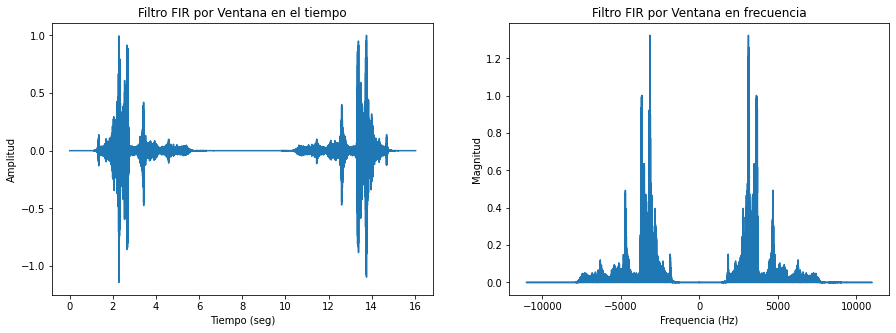

In [2129]:
audioFIRtiempo = np.fft.ifft(audioVentana)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(t,(audioFIRtiempo/max(audioFIRtiempo)))
plt.title('Filtro FIR por Ventana en el tiempo')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud')

plt.subplot(1, 2, 2)
plt.plot(freq, np.abs(audioFIRtiempo/max(audioFIRtiempo)))
plt.title('Filtro FIR por Ventana en frecuencia')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitud') 
plt.show()


Espectro del audio con el filtro FIR por Ventaneo

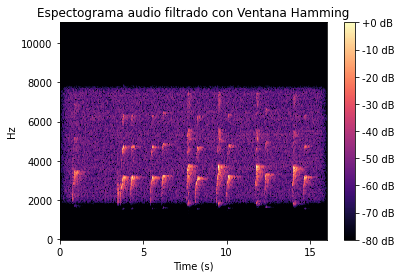

In [2130]:
cantoTucanVentanaFFT = librosa.stft(audioVentana, n_fft=512) 
amplitudDB = librosa.amplitude_to_db(np.abs(cantoTucanVentanaFFT), ref=np.max)

fig, ax = plt.subplots()
espectro = librosa.display.specshow(amplitudDB, sr=Fs, n_fft=512,hop_length=128, x_axis='s', y_axis='linear', ax=ax)
ax.set(title='Espectograma audio filtrado con Ventana Hamming')
plt.colorbar(espectro, ax=ax, format="%+2.f dB")

Espectograma comparando con Audio Resultante de FIRWIN

In [2131]:

y, Fs = librosa.load("CantoTucan.wav")
audioVentanaFIRWIN = signal.correlate(y, ventanaFiltradaFirwin, mode="same")
sf.write('resultadoVentanasFIR_FIRWIN.wav',np.real(audioVentanaFIRWIN/max(audioVentanaFIRWIN)),Fs)
ipd.Audio(audioVentanaFIRWIN, rate=Fs)


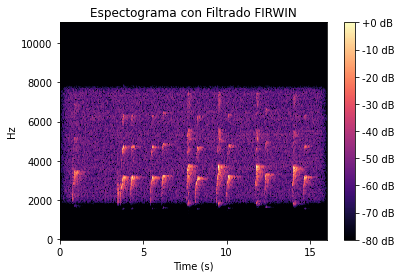

In [2132]:
cantoTucanFFT_FIRWIN = librosa.stft(audioVentanaFIRWIN, n_fft=512) 
amplitudDB_FIRWIN = librosa.amplitude_to_db(np.abs(cantoTucanFFT_FIRWIN), ref=np.max)

fig, ax = plt.subplots()
espectroFIRWIN = librosa.display.specshow(amplitudDB_FIRWIN, sr=Fs, n_fft=512,hop_length=128, x_axis='s', y_axis='linear', ax=ax)
ax.set(title='Espectograma con Filtrado FIRWIN')
plt.colorbar(espectroFIRWIN, ax=ax, format="%+2.f dB")

# FILTRO FIR POR APROXIMACIÓN DE CHEBYSHEV

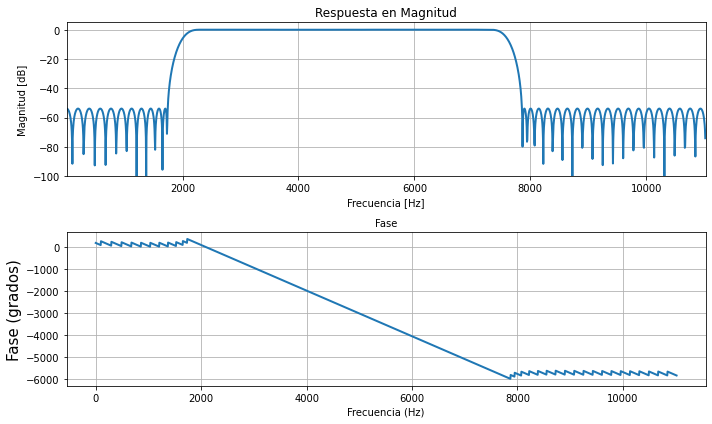

In [2133]:
from scipy.signal import remez

def chebyshevRemez(ntaps, corteInferior, corteSuperior, fs, width):
    delta = 0.5*width
    bordes = [0, corteInferior-delta, corteInferior+delta,
    corteSuperior-delta, corteSuperior+delta, 0.5*fs ]
    taps = remez(ntaps, bordes, [0, 1, 0], Hz=fs)
    return taps

remezWidth = 512
tapsRemez = chebyshevRemez(128, 2000, 7600, fs=fs, width=remezWidth)

ventanaChevyResultante, filtroChevyResultante = freqz(tapsRemez, 1, worN=2000)
graficarRespuestaFrecuencia(ventanaChevyResultante, filtroChevyResultante, fs )

Añadir filtro Chebyshev a audio

In [2134]:
audioChebyshev = signal.correlate(y, tapsRemez, mode="same")
sf.write('resultadoChebyshevFIR.wav',np.real(audioChebyshev/max(audioChebyshev)), Fs)
ipd.Audio(audioChebyshev, rate=Fs)

Espectograma filtro FIR por Chebyshev

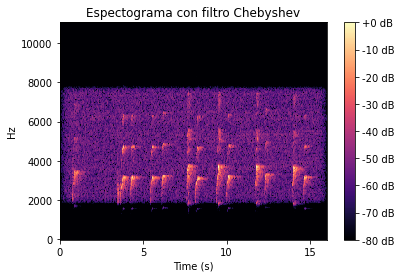

In [2135]:
cantoTucan_ChebyshevFFT = librosa.stft(audioChebyshev, n_fft=512) 
amplitud_ChebyshevDB = librosa.amplitude_to_db(np.abs(cantoTucan_ChebyshevFFT), ref=np.max)

fig, ax = plt.subplots()
spec = librosa.display.specshow(amplitud_ChebyshevDB, sr=Fs, n_fft=512,hop_length=128, x_axis='s', y_axis='linear', ax=ax)
ax.set(title='Espectograma con filtro Chebyshev')
plt.colorbar(spec, ax=ax, format="%+2.f dB")

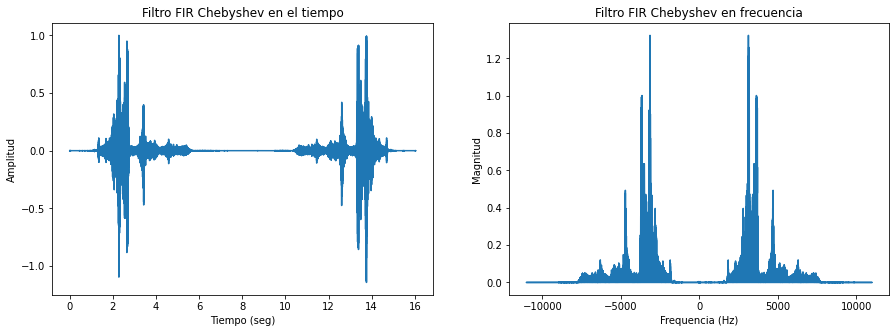

In [2136]:
audioChebyshevTiempo = np.fft.ifft(audioChebyshev)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(t,(audioChebyshevTiempo/max(audioChebyshevTiempo)))
plt.title('Filtro FIR Chebyshev en el tiempo')
plt.xlabel('Tiempo (seg)')
plt.ylabel('Amplitud')

plt.subplot(1, 2, 2)
plt.plot(freq, np.abs(audioChebyshevTiempo/max(audioChebyshevTiempo)))
plt.title('Filtro FIR Chebyshev en frecuencia')
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitud') 
plt.show()

# FUNCIÓN FILTRO IIR POR TRANSFORMACIÓN BILINEAL

In [2137]:
def IIRFilter(N, fs, fcInferior,  fcSuperior):
    # Calcula el tiempo de meustreo
    Td = 1/fs

    # Pasar frecuencia de corte a frecuencia angular
    wd1 = 2*np.pi*fcInferior
    wd2 = 2*np.pi*fcSuperior

    # Prewarp
    wc1 = (2/Td)*np.tan(wd1*Td/2)
    wc2 = (2/Td)*np.tan(wd2*Td/2)

    # Calcula coeficientes filtro Butterword
    b, a = signal.butter(N, [wc1, wc2], 'band', analog='True')

    # Calcula coeficientes filtro Bilineal
    z, p = signal.bilinear(b, a, fs=fs)

    # Retorna respuesta en frecuencia del filtro
    #w -> Vector de frecuencias donde se calculo
    #h-> Respuesta en la frecuencia
    #6000 -> cantidad de puntos del filtro 
    wz, hz = signal.freqz(z, p, 103799)
    Frecuencias = wz*fs/(2*np.pi) #Vuelve a llevar la frecuencias a Hz
    
    return [Frecuencias, hz]

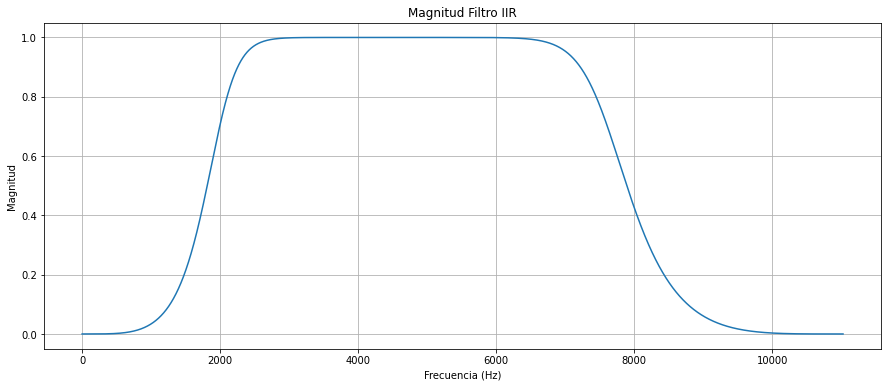

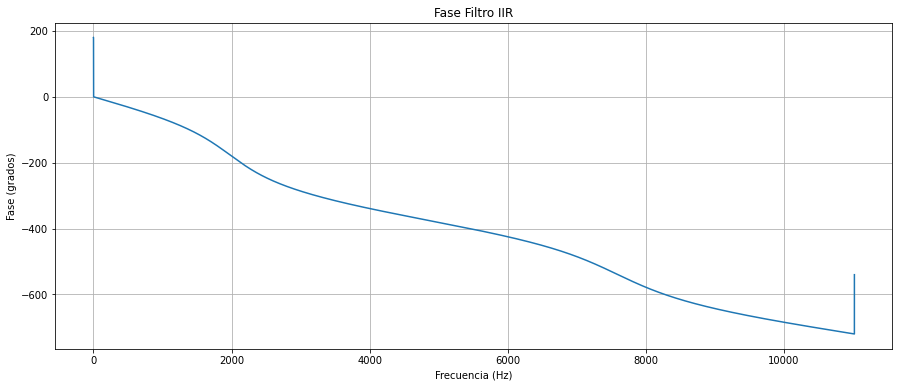

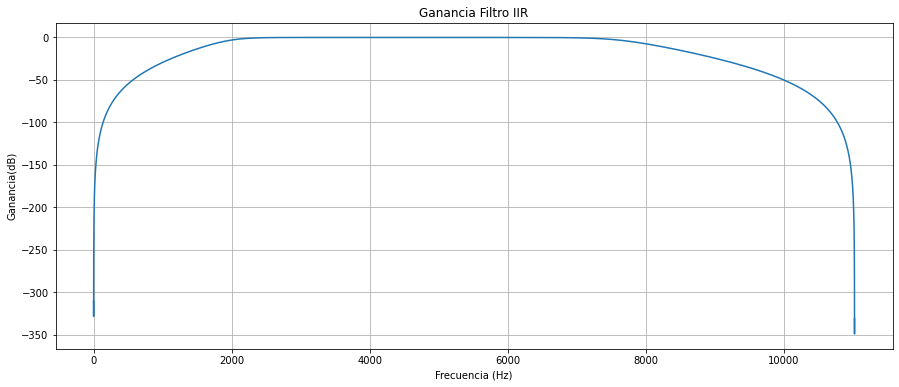

103799


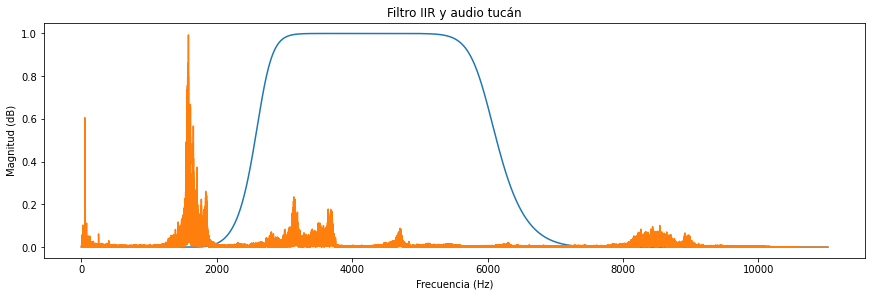

In [2138]:
f = np.linspace(0,fs,y.shape[0]) #vector de frecuencias 

#sacar el indice de la frecuencia de corte
def muestra(f,f1):
    for i in range (200000):
        if (int(f[i]) == f1):
            return i



N = 4 #Orden del filtro
fcInferiorIIR = 2000
fcSuperiorIIR = 7600 # Frecuencia de corte


[Frecuencias, Hz] = IIRFilter(N,fs,fcInferiorIIR, fcSuperiorIIR)


# Plotear Magnitud Filtro
plt.figure(figsize = (15,6))
plt.plot(Frecuencias, np.abs(Hz))
plt.grid()
plt.title('Magnitud Filtro IIR')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.show()
  
# Plotear Fase filtro
Phase = np.unwrap(np.angle(Hz))*180/np.pi
plt.figure(figsize = (15,6))
plt.plot(Frecuencias, Phase)
plt.grid()
plt.title('Fase Filtro IIR')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Fase (grados)')
plt.show()

# Plotear Ganancia en Decibeles
plt.figure(figsize = (15,6))
plt.plot(Frecuencias, 20*np.log10((np.abs(Hz))))
plt.grid()
plt.title('Ganancia Filtro IIR')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia(dB)')
plt.show()

print(len(Hz))
hzFinal = np.concatenate([np.zeros(muestra(f,fcInferiorIIR-500)),np.abs(Hz)])#Se concatena un vector de 1 antes del filtro
hzFinal = np.concatenate([hzFinal, np.zeros(len(f)-len(hzFinal))])


fig, (ax0) = plt.subplots(ncols = 1, constrained_layout = True, figsize = (12,4))
ax0.plot(f[0:round(len(x)/2)],np.abs( hzFinal[0:round(len(x)/2)] ), label = "Filtro IIR")
ax0.plot(f[0:round(len(x)/2)], (np.abs(x)/max(x))[0:round(len(x)/2)], label = "Audio normalizado") 
plt.title('Filtro IIR y audio tucán')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud (dB)")
plt.show()


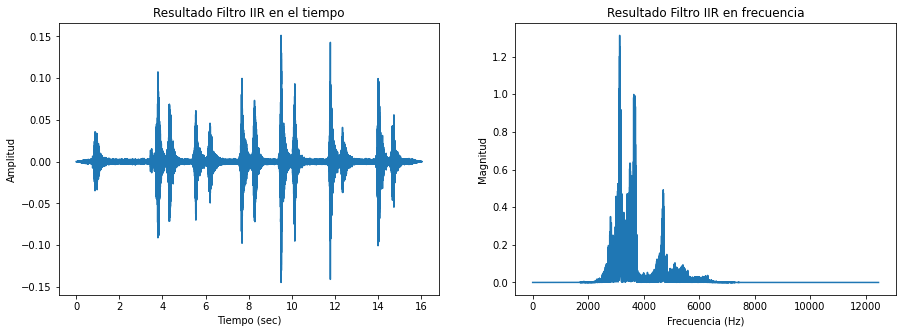

In [2139]:
HzFinalEnFrecuencia = (hzFinal) * x #Filtrar -> multiplicar la transormada X por el filtro
HzFinalFreqNormalizada = HzFinalEnFrecuencia/max(HzFinalEnFrecuencia) #Normalizacion
HzFinalTiempoBilinear = np.fft.ifft(HzFinalEnFrecuencia) #Se la aplica la transfrmada inversa para sacarla en el tiempo
    

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot( t, HzFinalTiempoBilinear)
plt.title('Resultado Filtro IIR en el tiempo')
plt.xlabel('Tiempo (sec)')
plt.ylabel('Amplitud')

plt.subplot(1, 2, 2)
plt.plot( f[0:200000],(np.abs(HzFinalFreqNormalizada))[0:200000] )
plt.title('Resultado Filtro IIR en frecuencia')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud') 
plt.show()

sf.write('resultadoIIR.wav', np.real(HzFinalTiempoBilinear), fs)

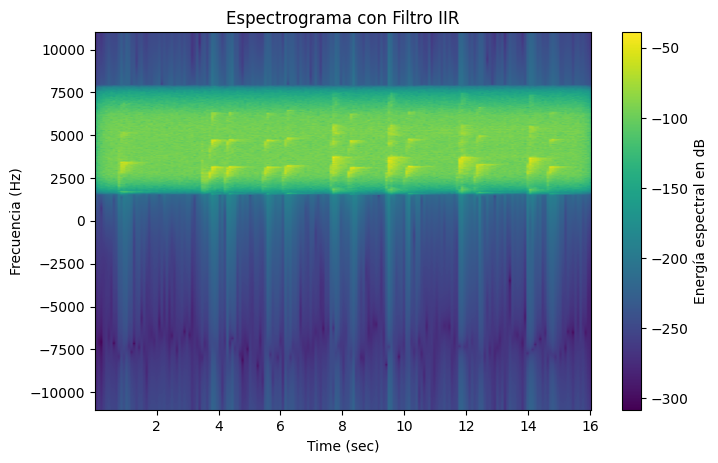

In [2140]:
plt.figure(figsize=(8, 5),dpi=100)
plt.specgram( HzFinalTiempoBilinear, Fs=fs, NFFT=2048, noverlap=256)
plt.title('Espectrograma con Filtro IIR')
plt.xlabel('Time (sec)')
plt.ylabel('Frecuencia (Hz)')
plt.colorbar(label="Energía espectral en dB")
plt.show()
